# Оценка качества эксперементальной модели

> Для корректной работы ссылок оглавления лучше смотреть проект здесь \
> https://nbviewer.org/github/experiment0/experiments/blob/master/decision_tree_with_logistic_regression/check.ipynb

## Оглавление

- [Сравнение результатов моделей на разных данных](#tables)
    - [Таблица "NASA | Nearest Earth Objects (1910-2024)"](#table_nasa)
    - [Таблица "Banana Quality"](#table_banana)
    - [Таблица "Diabetes prediction dataset"](#table_diabet)
    - [Таблица "Water Quality"](#table_water)
    - [Таблица "Plant Growth Data Classification"](#table_plant)
    - [Таблица "Bank Customer Churn"](#table_bank)
    - [Таблица "SALIFORT Motors Dataset"](#table_salifort)
    - [Таблица "Biomed"](#table_biomed)
- [Исследование модели `DecisionTreeWithLogisticRegression`](#research)
    - [Сравнение работы моделей при глубине дерева равной 1](#max_depth_1)
        - [Модель `DecisionTreeClassifier` из `sklearn`](#max_depth_1_cart)
        - [Модель `DecisionTreeWithLogisticRegression`](#max_depth_1_custom)
    - [Сравнение работы моделей при глубине дерева равной 2](#max_depth_2)
        - [Модель `DecisionTreeClassifier` из `sklearn`](#max_depth_2_cart)
        - [Модель `DecisionTreeWithLogisticRegression`](#max_depth_2_custom)
    - [Сравнение работы моделей при глубине дерева равной 3](#max_depth_3)
        - [Модель `DecisionTreeClassifier` из `sklearn`](#max_depth_3_cart)
        - [Модель `DecisionTreeWithLogisticRegression`](#max_depth_3_custom)
    - [Сравнение работы моделей при глубине дерева равной 4](#max_depth_4)
        - [Модель `DecisionTreeClassifier` из `sklearn`](#max_depth_4_cart)
        - [Модель `DecisionTreeWithLogisticRegression`](#max_depth_4_custom)
- [Вывод](#result)

Сравним результаты дерева решений, построенного по алгоритму **CART** (Classification and Regression Tree) \
(реализован в классе `DecisionTreeClassifier` из `sklearn`)\
и эксперементального дерева решений, реализованнного в классе `DecisionTreeWithLogisticRegression`.

Для этого рассмотрим несколько [наборов данных для бинарной классификации,
представленных на kaggle](https://www.kaggle.com/datasets?tags=14201-Binary+Classification).

Будем рассматривать, как меняется метрика $F_1$ в зависимости от глубины дерева для двух моделей.\
Метрику $F_1$ выбираем по той причине, что значение целевой переменной может быть не сбалансировано на разных данных 
и нам важно посмотреть на качество разбиения в целом.

In [41]:
import pandas as pd
import numpy as np
from sklearn import tree, metrics, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from time import time
import datetime
from typing import Tuple, Union, Optional, Any
import seaborn as sns 
import matplotlib.pyplot as plt 
from enum import Enum
from IPython.display import HTML, display

from classes.DecisionTreeWithLogisticRegression import (
    Node,
    DecisionTreeWithLogisticRegression,
)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [81]:
# тип модели
class ModelType(Enum):
    # модель, реализованная в sklearn по алгоритму CART
    CART = 'cart'
    # эксперементальная модель, реализованная в классе DecisionTreeWithLogisticRegression
    CUSTOM = 'custom'


# Вспомогательные функции

def show_pie(col_data: pd.Series, title: str = 'Соотношение значений целевой переменной'):
    """Выводит круговую диаграмму распределения значений признака

    Args:
        col_data (pd.Series): данные признака, для которого нужно вывести круговую диаграмму
        title (str, optional): Заголовок графика. 
            По умолчанию 'Соотношение значений целевой переменной'.
    """
    counts = col_data.value_counts()

    fig = plt.figure(figsize=(4, 4))
    axes = fig.add_axes([0, 0, 1, 1])

    axes.set_title(title)
    axes.pie(
        counts,
        labels=counts.index,
        autopct='%.1f%%',
    );
    

def get_scaled_split(X: pd.DataFrame, y: pd.Series) -> Tuple[
    pd.DataFrame, pd.DataFrame, pd.Series, pd.Series
]:
    """Возвращает масштабированные данные, разделенные на тренировочную и тестовую выборки

    Args:
        X (pd.DataFrame): данные выборки (предикторы)
        y (pd.Series): истинные значения целевой переменной

    Returns:
        Tuple[ pd.DataFrame, pd.DataFrame, pd.Series, pd.Series ]: 
            масштабированные данные тренировочной и тестовой выборок
    """
    # разделяем на тренировочную и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

    # имена столбцов
    col_names = list(X.columns)

    # создаем объект для min-max нормализации
    scaler = preprocessing.MinMaxScaler()

    # вычисляем параметры для нормализации - min и max для каждого столбца
    scaler.fit(X_train)

    # производим преобразование для каждой из выборок
    X_train_scaled = scaler.transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_names)

    X_test_scaled = scaler.transform(X_test)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_names)
    
    return X_train_scaled, X_test_scaled, y_train, y_test


def get_f1_scores(
        model_type: ModelType, 
        max_depth: int, 
        X_train: pd.DataFrame, 
        y_train: pd.Series, 
        X_test: pd.DataFrame = None, 
        y_test: pd.Series = None,
    ) -> Tuple[float, float]:
    """Возвращает значения метрики F1 для тренировочной и тестовой (опционально) выборок

    Args:
        model_type (ModelType): тип модели        
        max_depth (int): глубина дерева
        X_train (pd.DataFrame): данные тренировочной выборки
        y_train (pd.Series): истинные значения целевой переменной для тренировочной выборки
        X_test (pd.DataFrame, optional): данные тестовой выборки
            По умолчанию None.
        y_test (pd.Series, optional): истинные значения целевой переменной для тестовой выборки
            По умолчанию None.

    Returns:
        Tuple[float, float]: значения метрики F1 для тренировочной и тестовой выборок
    """
    should_count_test_data = X_test is not None
    
    # инициализируем модель дерева решений
    if (model_type == ModelType.CART.value):
        dtc_model = tree.DecisionTreeClassifier(
            max_depth=max_depth,
            criterion='entropy',
            random_state=42,
        )
    elif (model_type == ModelType.CUSTOM.value):
        dtc_model = DecisionTreeWithLogisticRegression(max_depth=max_depth)

    # обучаем
    dtc_model.fit(X_train, y_train)

    # делаем предсказания и считаем метрики
    y_train_pred = dtc_model.predict(X_train)
    f1_train = metrics.f1_score(y_train, y_train_pred)

    f1_test = 0
    if (should_count_test_data):
        y_test_pred = dtc_model.predict(X_test)
        f1_test = metrics.f1_score(y_test, y_test_pred)

    # возвращаем полученные значения метрик
    return f1_train, f1_test


def comparison_of_tree_models(
        X_train: pd.DataFrame, 
        y_train: pd.Series, 
        X_test: pd.DataFrame = None, 
        y_test: pd.Series = None,
    ):
    """Выводит графики соответствия глубины дерева и метрики F1 для стандартной и эксперементальной моделей

    Args:
        X_train (pd.DataFrame): данные тренировочной выборки
        y_train (pd.Series): истинные значения для тренировочной выборки
        X_test (pd.DataFrame, optional): данные тестовой выборки. 
            По умолчанию None.
        y_test (pd.Series, optional): истинные значения для тестовой выборки. 
            По умолчанию None.
    """
    should_display_test_data = X_test is not None
    
    # диапазон глубины деревьев, на которой будем смотреть метрику f1
    max_depths = range(2, 9)

    # списки значений метрики f1 для дерева решений из sklearn, построенного по алгоритму CART
    cart_model_f1_train_scores = []
    if (should_display_test_data):
        cart_model_f1_test_scores = []
    
    # списки значений метрики f1 для эксперементального дерева решений, 
    # реализованного в классе DecisionTreeWithLogisticRegression
    custom_model_f1_train_scores = []
    if (should_display_test_data):
        custom_model_f1_test_scores = []

    # итерируемся по значениям глубины дерева из sklearn, построенного по алгоритму CART
    for max_depth in max_depths:
        # считаем метрики F1 для дерева решений 
        f1_train, f1_test = get_f1_scores(
            ModelType.CART.value, max_depth, X_train, y_train, X_test, y_test
        )
        # запоминаем метрики в списки
        cart_model_f1_train_scores.append(f1_train)
        if (should_display_test_data):
            cart_model_f1_test_scores.append(f1_test)
        
        # считаем метрики f1 для эксперементального дерева решений, 
        # реализованного в классе DecisionTreeWithLogisticRegression
        f1_train, f1_test = get_f1_scores(
            ModelType.CUSTOM.value, max_depth, X_train, y_train, X_test, y_test
        )
        # запоминаем метрики в списки
        custom_model_f1_train_scores.append(f1_train)
        if (should_display_test_data):
            custom_model_f1_test_scores.append(f1_test)
    
    # фигура + координатная плоскость
    fig, ax = plt.subplots(figsize=(14, 7)) 

    # графики значения метрики F1 для модели CART
    ax.plot(
        max_depths, 
        cart_model_f1_train_scores, 
        color='#FF8C00', 
        label='DecisionTreeClassifier Train'
    ) 
    if (should_display_test_data):
        ax.plot(
            max_depths, 
            cart_model_f1_test_scores, 
            color='#FF0000', 
            label='DecisionTreeClassifier Test'
        ) 

    # графики значения метрики F1 для эксперементальной модели
    ax.plot(
        max_depths, 
        custom_model_f1_train_scores, 
        color='#00BFFF', 
        label='DecisionTreeWithLogisticRegression Train'
    ) 
    if (should_display_test_data):
        ax.plot(
            max_depths, 
            custom_model_f1_test_scores, 
            color='#0000FF', 
            label='DecisionTreeWithLogisticRegression Test'
        ) 
    
    # заголовок
    ax.set_title('Зависимость метрики F1 от глубины дерева')
    # подпись по оси абсцисс
    ax.set_xlabel('Глубина дерева (max_depth)') 
    # подпись по оси ординат
    ax.set_ylabel('Значение метрики F1') 
    # метки по оси абсцисс
    ax.set_xticks(max_depths) 
    # отображение легенды
    ax.legend();

## Сравнение результатов моделей на разных данных <a id="tables"></a>

### Таблица "NASA | Nearest Earth Objects (1910-2024)" <a id="table_nasa"></a>

> Источник данных:\
> https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024

В таблице представлены данные об астероидах.

**Описание столбцов:**

- `neo_id` - Уникальный идентификатор для каждого астероида
- `name` - Название данное NASA
- `absolute_magnitude` - Описывает внутреннюю светимость
- `estimated_diameter_min` - Минимальный расчетный диаметр в километрах
- `estimated_diameter_max` - Максимальный расчетный диаметр в километрах
- `orbiting_body` - Планета, вокруг которой вращается астероид
- `relative_velocity` - Скорость относительно Земли в км/ч
- `miss_distance` - Distance in Kilometres missed
- `is_hazardous` - Булева функция, показывающая, является ли астероид опасным или нет (**целевая переменная**)

In [4]:
# загрузим данные
data_asteroid = pd.read_csv('./data/nearest-earth-objects-1910-2024.csv')
data_asteroid.head()

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False


Приведем данные к виду, пригодному для передачи в модель.

In [5]:
# удалим лишние признаки
data_asteroid.drop(columns=['neo_id', 'name', 'orbiting_body'], inplace=True)
# удалим пропуски
data_asteroid.dropna(inplace=True)
# приведем значения целевой переменной к 0 и 1
data_asteroid['is_hazardous'] = data_asteroid['is_hazardous'].apply(lambda value: 0 if value == False else 1)
# удалим дубликаты
data_asteroid.drop_duplicates(inplace=True)

data_asteroid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338166 entries, 0 to 338198
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   absolute_magnitude      338166 non-null  float64
 1   estimated_diameter_min  338166 non-null  float64
 2   estimated_diameter_max  338166 non-null  float64
 3   relative_velocity       338166 non-null  float64
 4   miss_distance           338166 non-null  float64
 5   is_hazardous            338166 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 18.1 MB


Пропусков нет, все данные числовые.

In [6]:
# признаки
X = data_asteroid.drop(['is_hazardous'], axis = 1)
# целевой признак
y = data_asteroid['is_hazardous']

# разделим выборку на тренировочную и тестовую и масштабируем данные
X_train_scaled, X_test_scaled, y_train, y_test = get_scaled_split(X, y)

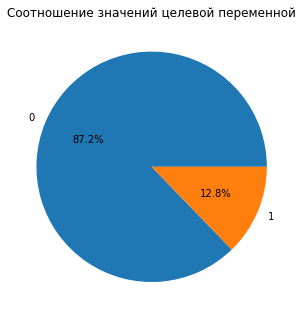

In [9]:
show_pie(y)

Как видим, данные не сбалансированы.

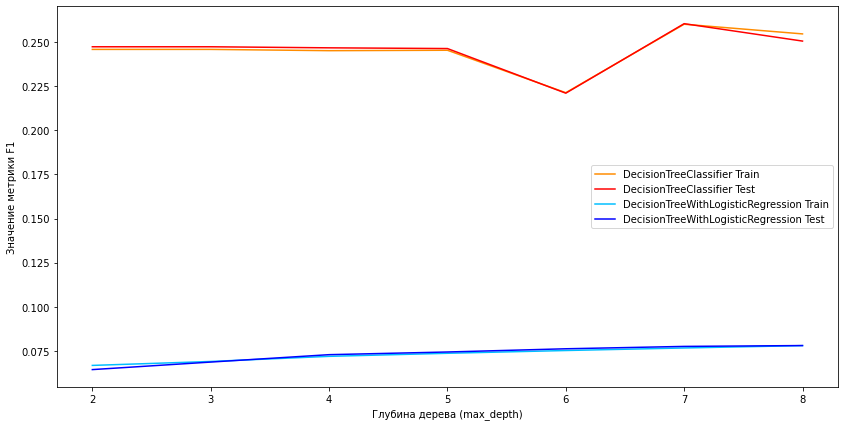

In [10]:
comparison_of_tree_models(X_train_scaled, y_train, X_test_scaled, y_test)

> Как видим, значение метрики F1 для эксперементальной модели здесь низкое и растет медленно.

### Таблица "Banana Quality" <a id="table_banana"></a>

> Источник данных:\
> https://www.kaggle.com/datasets/l3llff/banana

В таблице представлены данные о характеристиках бананов.

**Описание столбцов:**

- `Size` - размер
- `Weight` - вес
- `Sweetness` - сладость
- `Softness` - мягкость 
- `HarvestTime` - время сбора урожая
- `Ripeness` - спелость
- `Acidity` - кислотность
- `Quality` - качество (**целевая переменная**)

In [25]:
# загрузим данные
data_banana = pd.read_csv('./data/banana_quality.csv')
data_banana.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,-1.924968,0.468078,3.077832,-1.472177,0.294799,2.435570,0.271290,Good
1,-2.409751,0.486870,0.346921,-2.495099,-0.892213,2.067549,0.307325,Good
2,-0.357607,1.483176,1.568452,-2.645145,-0.647267,3.090643,1.427322,Good
3,-0.868524,1.566201,1.889605,-1.273761,-1.006278,1.873001,0.477862,Good
4,0.651825,1.319199,-0.022459,-1.209709,-1.430692,1.078345,2.812442,Good


Приведем данные к виду, пригодному для передачи в модель.

In [26]:
# приведем целевой признак к значениям 0 и 1
data_banana['Quality'] = data_banana['Quality'].apply(lambda value: 1 if value == 'Good' else 0)
# удалим дубликаты
data_banana.drop_duplicates(inplace=True)

data_banana.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         8000 non-null   float64
 1   Weight       8000 non-null   float64
 2   Sweetness    8000 non-null   float64
 3   Softness     8000 non-null   float64
 4   HarvestTime  8000 non-null   float64
 5   Ripeness     8000 non-null   float64
 6   Acidity      8000 non-null   float64
 7   Quality      8000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 562.5 KB


Пропусков нет, все данные числовые.

In [27]:
# признаки
X = data_banana.drop(['Quality'], axis = 1)
# целевой признак
y = data_banana['Quality']

# разделим выборку на тренировочную и тестовую и масштабируем данные
X_train_scaled, X_test_scaled, y_train, y_test = get_scaled_split(X, y)

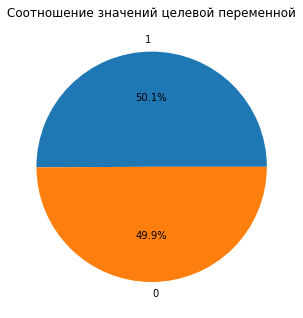

In [28]:
show_pie(y)

Как видим, данные сбалансированы.

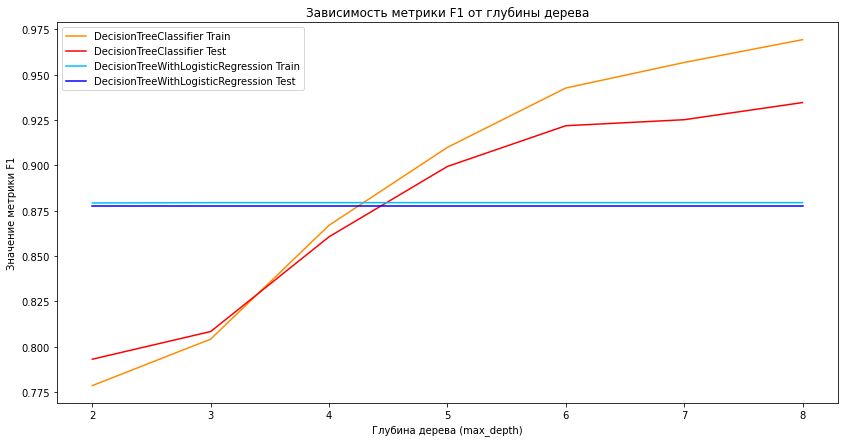

In [29]:
comparison_of_tree_models(X_train_scaled, y_train, X_test_scaled, y_test)

> На начальных значениях глубины дерева эксперементальная модель показывает лучшие значения.\
> Но после значения 4 классическая модель CART ее обгоняет, а метрика $F_1$ у эксперементальной модели вообще не растет. 

### Таблица "Diabetes prediction dataset" <a id="table_diabet"></a>

> Источник данных:\
> https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

В таблице представлены данные для прогнозирования диабета.

**Описание признаков:**

- `gender` - Гендер относится к биологическому полу человека, который может влиять на восприимчивость к диабету. В нем есть три категории: мужской, женский и другой.
- `age` - Возраст является важным фактором, поскольку диабет чаще диагностируется у пожилых людей. В нашем наборе данных возраст варьируется от 0 до 80 лет.
- `hypertension` - Гипертония — это медицинское состояние, при котором артериальное давление в артериях постоянно повышено. Оно имеет значения 0 или 1, где 0 означает, что у них нет гипертонии, а 1 — что у них есть гипертония.
- `heart_disease` - Сердечно-сосудистые заболевания — еще одно медицинское состояние, связанное с повышенным риском развития диабета. Оно имеет значения 0 или 1, где 0 означает, что у них нет сердечно-сосудистых заболеваний, а 1 означает, что у них есть сердечно-сосудистые заболевания.
- `smoking_history` - Курение в анамнезе также считается фактором риска развития диабета и может усугубить осложнения, связанные с диабетом. В нашем наборе данных есть 5 категорий: «не курил», «в прошлом», «нет информации», «в настоящее время», «никогда» и «когда-либо».
- `bmi` - ИМТ (индекс массы тела) — это показатель содержания жира в организме на основе веса и роста. Более высокие значения ИМТ связаны с более высоким риском развития диабета. Диапазон ИМТ в наборе данных составляет от 10,16 до 71,55. ИМТ менее 18,5 — недостаточный вес, 18,5–24,9 — нормальный вес, 25–29,9 — избыточный вес, а 30 и более — ожирение.
- `HbA1c_level` - Уровень HbA1c (гемоглобин A1c) — это показатель среднего уровня сахара в крови человека за последние 2–3 месяца. Более высокие уровни указывают на более высокий риск развития диабета. В основном более 6,5% уровня HbA1c указывает на диабет.
- `blood_glucose_level` - Уровень глюкозы в крови относится к количеству глюкозы в крови в определенное время. Высокий уровень глюкозы в крови является ключевым показателем диабета.
- `diabetes` - Диабет — это прогнозируемая **целевая переменная**, при этом значение 1 указывает на наличие диабета, а 0 — на отсутствие диабета.

In [30]:
# загрузим данные
data_diabetes = pd.read_csv('./data/diabetes_prediction_dataset.csv')
data_diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


Приведем данные к виду, пригодному для передачи в модель.

In [32]:
# удалим дубликаты
data_diabetes.drop_duplicates(inplace=True)
# кодируем категориальные переменные
data_diabetes = pd.get_dummies(data_diabetes)
data_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96146 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          96146 non-null  float64
 1   hypertension                 96146 non-null  int64  
 2   heart_disease                96146 non-null  int64  
 3   bmi                          96146 non-null  float64
 4   HbA1c_level                  96146 non-null  float64
 5   blood_glucose_level          96146 non-null  int64  
 6   diabetes                     96146 non-null  int64  
 7   gender_Female                96146 non-null  uint8  
 8   gender_Male                  96146 non-null  uint8  
 9   gender_Other                 96146 non-null  uint8  
 10  smoking_history_No Info      96146 non-null  uint8  
 11  smoking_history_current      96146 non-null  uint8  
 12  smoking_history_ever         96146 non-null  uint8  
 13  smoking_history_

Пропусков нет, все данные числовые.

In [33]:
# признаки
X = data_diabetes.drop(['diabetes'], axis = 1)
# целевой признак
y = data_diabetes['diabetes']

# разделим выборку на тренировочную и тестовую и масштабируем данные
X_train_scaled, X_test_scaled, y_train, y_test = get_scaled_split(X, y)

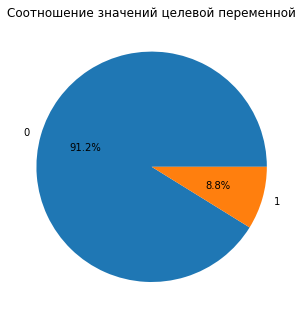

In [34]:
show_pie(y)

Как видим, данные не сбалансированы.

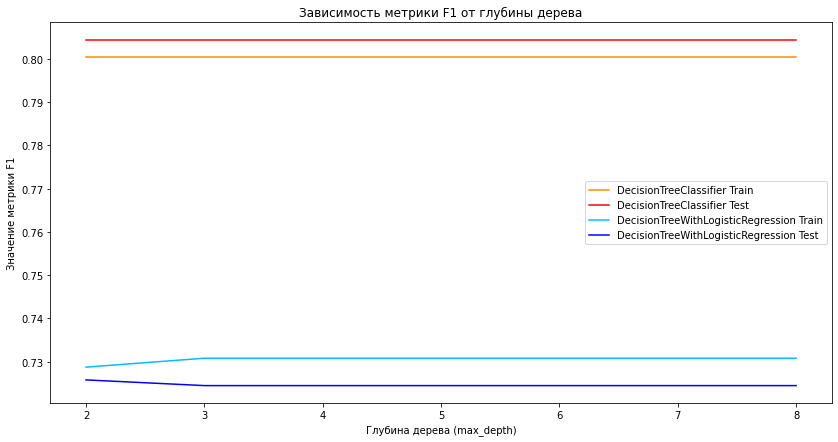

In [35]:
comparison_of_tree_models(X_train_scaled, y_train, X_test_scaled, y_test)

> Как видим, у обеих моделей значение метрики $F_1$ не растет при увеличении глубины дерева.\
> Но у эксперементальной модели значение $F_1$ намного ниже.

### Таблица "Water Quality" <a id="table_water"></a>

> Источник данных:\
> https://www.kaggle.com/datasets/adityakadiwal/water-potability

В таблице представлены данные о качестве воды.

**Описание признаков**

- `ph` - pH воды (от 0 до 14).
- `Hardness` - Способность воды осаждаться мылом в мг/л (жесткость).
- `Solids` - Общее количество растворенных твердых веществ в ppm.
- `Chloramines` - Количество хлораминов в ppm.
- `Sulfate` - Количество растворенных сульфатов в мг/л.
- `Conductivity` - Электропроводность воды в мкСм/см.
- `Organic_carbon` - Количество органического углерода в ppm.
- `Trihalomethanes` - Количество тригалометанов в мкг/л.
- `Turbidity` - Мера светоизлучающей способности воды в NTU.
- `Potability` - Указывает, безопасна ли вода для потребления человеком. \
Питьевая -1 и непитьевая -0 (**целевой признак**).

In [36]:
# загрузим данные
data_water = pd.read_csv('./data/water_potability.csv')
data_water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Приведем данные к виду, пригодному для передачи в модель.

In [38]:
# удалим пропуски
data_water.dropna(inplace=True)
# удалим дубликаты
data_water.drop_duplicates(inplace=True)

data_water.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


Пропусков нет, все данные числовые.

In [39]:
# признаки
X = data_water.drop(['Potability'], axis = 1)
# целевой признак
y = data_water['Potability']

# разделим выборку на тренировочную и тестовую и масштабируем данные
X_train_scaled, X_test_scaled, y_train, y_test = get_scaled_split(X, y)

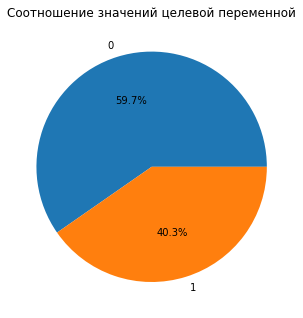

In [40]:
show_pie(y)

Несбалансированность данных не такая уж большая.

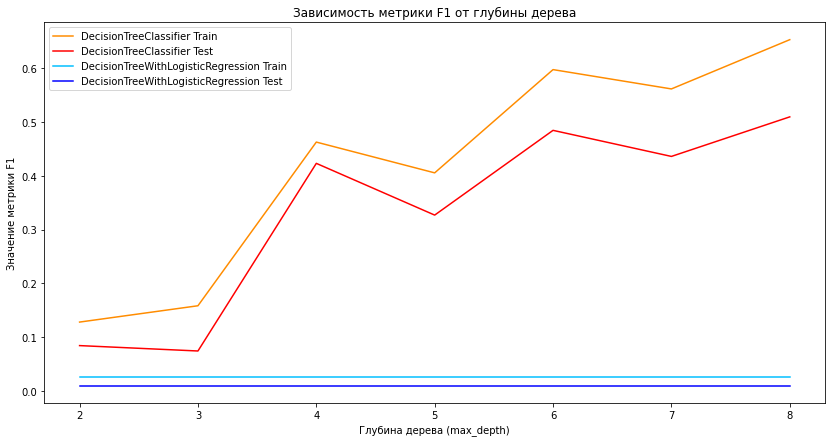

In [41]:
comparison_of_tree_models(X_train_scaled, y_train, X_test_scaled, y_test)

> Видим, что у классической модели метрика $F_1$ растет, \
> а у эксперементальной модели - низкая и не растет.

### Таблица "Plant Growth Data Classification" <a id="table_plant"></a>

> Источник данных:\
> https://www.kaggle.com/datasets/gorororororo23/plant-growth-data-classification

Таблица содержит данные о росте растений.

Описание столбцов:

- `Soil_Type` - Тип или состав почвы, в которой выращиваются растения.
- `Sunlight_Hours` - Продолжительность или интенсивность воздействия солнечного света на растения.
- `Water_Frequency` - Частота полива растений, с указанием графика полива.
- `Fertilizer_Type` - Тип удобрения, используемого для питания растений.
- `Temperature` - Температура окружающей среды, в которой выращиваются растения.
- `Humidity` - Уровень влажности или влажности в окружающей среде, окружающей растения.
- `Growth_Milestone` - Описания или маркеры, указывающие стадии или значимые события в процессе роста растений (**целевая переменная**).

In [42]:
# загрузим данные
data_plant = pd.read_csv('./data/plant_growth_data.csv')
data_plant.head()

,Soil_Type,Sunlight_Hours,Water_Frequency,Fertilizer_Type,Temperature,Humidity,Growth_Milestone
0,loam,5.192294,bi-weekly,chemical,31.719602,61.591861,0
1,sandy,4.033133,weekly,organic,28.919484,52.422276,1
2,loam,8.892769,bi-weekly,none,23.179059,44.660539,0
3,loam,8.241144,bi-weekly,none,18.465886,46.433227,0
4,sandy,8.374043,bi-weekly,organic,18.128741,63.625923,0


Приведем данные к виду, пригодному для передачи в модель.

In [43]:
# удалим дубликаты
data_plant.drop_duplicates(inplace=True)
# кодируем категориальные признаки
data_plant = pd.get_dummies(data_plant)

data_plant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 192
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Sunlight_Hours             193 non-null    float64
 1   Temperature                193 non-null    float64
 2   Humidity                   193 non-null    float64
 3   Growth_Milestone           193 non-null    int64  
 4   Soil_Type_clay             193 non-null    uint8  
 5   Soil_Type_loam             193 non-null    uint8  
 6   Soil_Type_sandy            193 non-null    uint8  
 7   Water_Frequency_bi-weekly  193 non-null    uint8  
 8   Water_Frequency_daily      193 non-null    uint8  
 9   Water_Frequency_weekly     193 non-null    uint8  
 10  Fertilizer_Type_chemical   193 non-null    uint8  
 11  Fertilizer_Type_none       193 non-null    uint8  
 12  Fertilizer_Type_organic    193 non-null    uint8  
dtypes: float64(3), int64(1), uint8(9)
memory usage: 9.

Пропусков нет, все данные числовые.

In [44]:
# признаки
X = data_plant.drop(['Growth_Milestone'], axis = 1)
# целевой признак
y = data_plant['Growth_Milestone']

# разделим выборку на тренировочную и тестовую и масштабируем данные
X_train_scaled, X_test_scaled, y_train, y_test = get_scaled_split(X, y)

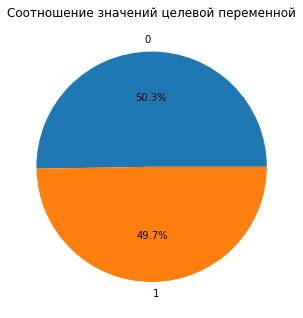

In [45]:
show_pie(y)

Данные сбалансированы.

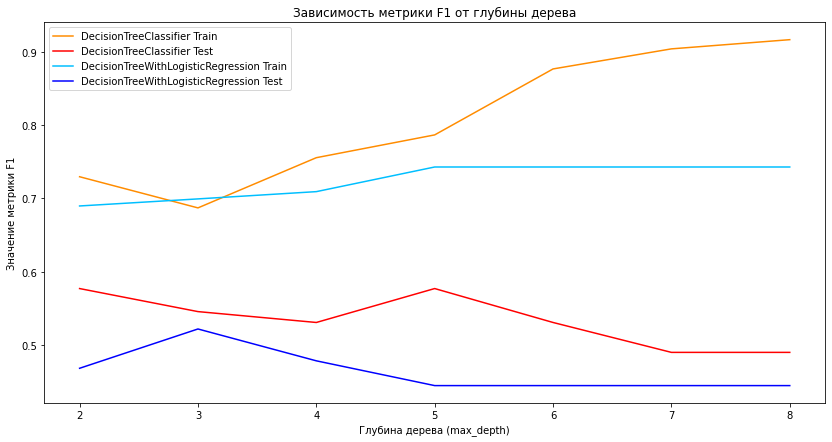

In [46]:
comparison_of_tree_models(X_train_scaled, y_train, X_test_scaled, y_test)

> У обоих моделей наблюдается переобучение даже на небольшой глубине дерева.\
> На тестовой выборке значение метрики $F_1$ у эксперементальной модели хуже.

### Таблица "Bank Customer Churn" <a id="table_bank"></a>

> Источник данных:\
> https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn

В таблице представлены данные о клиентах банка.

**Описание признаков**

- `RowNumber` — Номер записи (строки).
- `CustomerId` — Идентификатор клиента.
- `Surname` — Фамилия клиента.
- `CreditScore` — Кредитный рейтинг. 
- `Geography` — Местоположение клиента.
- `Gender` — Пол. 
- `Age` — Возраст. 
- `Tenure` — Относится к количеству лет, в течение которых клиент был клиентом банка. 
- `Balance` — Баланс. 
- `NumOfProducts` — Количество продуктов, которые клиент приобрел через банк.
- `HasCrCard` — Есть ли у клиента кредитная карта. 
- `IsActiveMember` — Является ли клиент активным. 
- `EstimatedSalary` — Предполагаемая зарплата. 
- `Exited` — Покинул ли клиент банк (**целевой признак**).
- `Complain` — Есть ли у клиента жалоба или нет.
- `Satisfaction Score` — Оценка, предоставленная клиентом для разрешения его жалобы.
- `Card Type` — Тип карты, которой владеет клиент.
- `Points Earned` — Баллы, заработанные клиентом за использование кредитной карты.

In [48]:
# загрузим данные
data_bank = pd.read_csv('./data/Customer-Churn-Records.csv')
data_bank.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


Приведем данные к виду, пригодному для передачи в модель.

In [49]:
# удалим лишние признаки
data_bank.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
# Приведем признак Gender к числовому бинарному
data_bank['Gender'] = data_bank['Gender'].apply(lambda value: 0 if value == 'Female' else 1)
# удалим дубликаты
data_bank.drop_duplicates(inplace=True)
# перекодируем категориальные признаки
data_bank = pd.get_dummies(data_bank)

data_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CreditScore         10000 non-null  int64  
 1   Gender              10000 non-null  int64  
 2   Age                 10000 non-null  int64  
 3   Tenure              10000 non-null  int64  
 4   Balance             10000 non-null  float64
 5   NumOfProducts       10000 non-null  int64  
 6   HasCrCard           10000 non-null  int64  
 7   IsActiveMember      10000 non-null  int64  
 8   EstimatedSalary     10000 non-null  float64
 9   Exited              10000 non-null  int64  
 10  Complain            10000 non-null  int64  
 11  Satisfaction Score  10000 non-null  int64  
 12  Point Earned        10000 non-null  int64  
 13  Geography_France    10000 non-null  uint8  
 14  Geography_Germany   10000 non-null  uint8  
 15  Geography_Spain     10000 non-null  uint8  
 16  Card 

Пропусков нет, все данные числовые.

In [50]:
# признаки
X = data_bank.drop(['Exited'], axis = 1)
# целевой признак
y = data_bank['Exited']

# разделим выборку на тренировочную и тестовую и масштабируем данные
X_train_scaled, X_test_scaled, y_train, y_test = get_scaled_split(X, y)

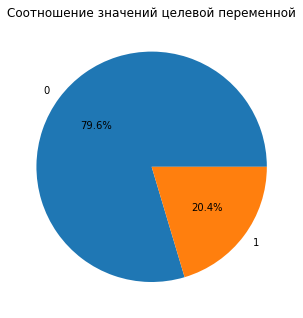

In [51]:
show_pie(y)

Данные не сбалансированы.

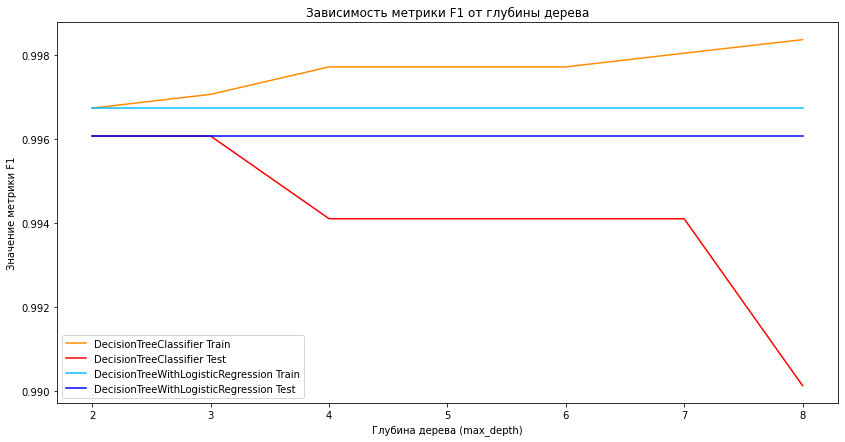

In [52]:
comparison_of_tree_models(X_train_scaled, y_train, X_test_scaled, y_test)

> Тут мы видим, что эксперементальная модель показала лучший результат, чем классическая.\
> Но значение метрики $F_1$ по прежнему не растет с увеличением глубины дерева.

### Таблица "SALIFORT Motors Dataset" <a id="table_salifort"></a>

> Источник данных:\
> https://www.kaggle.com/datasets/jacopoferretti/salifort-motors-dataset

Таблица содержит данные о сотрудниках компании Salifort.

**Описание признаков** не приведено в источнике.\
Целевой переменной является `left` - покинет ли сотрудник компанию.

In [53]:
# загрузим данные
data_hr = pd.read_csv('./data/HR_Sailfort_dataset.csv')
data_hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Приведем данные к виду, пригодному для передачи в модель.

In [54]:
# удалим дубликаты
data_hr.drop_duplicates(inplace=True)
# кодируем категориальные признаки
data_hr = pd.get_dummies(data_hr)

data_hr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 0 to 11999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      11991 non-null  float64
 1   last_evaluation         11991 non-null  float64
 2   number_project          11991 non-null  int64  
 3   average_montly_hours    11991 non-null  int64  
 4   time_spend_company      11991 non-null  int64  
 5   Work_accident           11991 non-null  int64  
 6   left                    11991 non-null  int64  
 7   promotion_last_5years   11991 non-null  int64  
 8   Department_IT           11991 non-null  uint8  
 9   Department_RandD        11991 non-null  uint8  
 10  Department_accounting   11991 non-null  uint8  
 11  Department_hr           11991 non-null  uint8  
 12  Department_management   11991 non-null  uint8  
 13  Department_marketing    11991 non-null  uint8  
 14  Department_product_mng  11991 non-null

Пропусков нет, все данные числовые.

In [55]:
# признаки
X = data_hr.drop(['left'], axis = 1)
# целевой признак
y = data_hr['left']

# разделим выборку на тренировочную и тестовую и масштабируем данные
X_train_scaled, X_test_scaled, y_train, y_test = get_scaled_split(X, y)

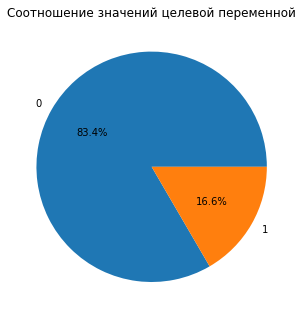

In [56]:
show_pie(y)

Данные не сбалансированы.

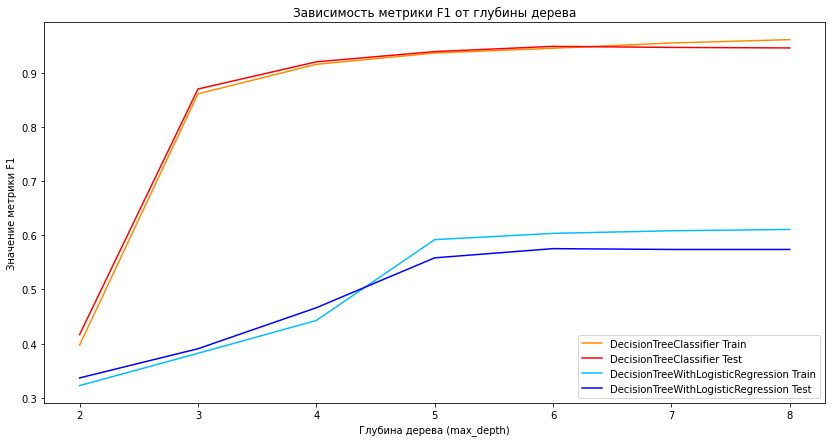

In [57]:
comparison_of_tree_models(X_train_scaled, y_train, X_test_scaled, y_test)

> Тут видим, что значение метрики $F_1$ у эксперементальной модели все же растет при увеличении глубины дерева до значения 5.\
> Затем расти перестает.\
> Но значение метрики ниже, чем у классической модели.

### Таблица "Biomed" <a id="table_biomed"></a>

> Данные взяты из библиотеки  `fetch_openml`.

Таблица содержит данные об анализах крови на редкое генетическое заболевание.

**Описание признаков**

- `Observation_number` - номер наблюдения
- `Hospital_identification_number_for_blood_sample` - идентификационный номер больницы для образца крови
- `Age_of_patient` - возраст пациента
- `Date_that_blood_sample_was_taken` - дата взятия образца крови
- `M1` - сывороточная креатинкиназа.
- `M2` - гемопексин.
- `M3` - пируваткиназа.
- `M4` - лактатдегидрогеназа.
- `class` - наличие заболевания (*normal* - нет, *carrier* - является переносчиком), **целевой признак**

In [43]:
# загрузим данные
data_biomed_full = fetch_openml(name='biomed')
data_biomed = data_biomed_full['frame']
data_biomed.head()

,Observation_number,Hospital_identification_number_for_blood_sample,Age_of_patient,Date_that_blood_sample_was_taken,ml,m2,m3,m4,class
0,1,1027,30,100078,167.0,89.0,25.6,364.0,carrier
1,1,1013,41,100078,104.0,81.0,26.8,245.0,carrier
2,1,1324,22,80079,30.0,108.0,8.8,284.0,carrier
3,2,1332,22,80079,44.0,104.0,17.4,172.0,carrier
4,1,966,20,100078,65.0,87.0,23.8,198.0,carrier


Приведем данные к виду, пригодному для передачи в модель.

In [44]:
# для удалим лишние признаки
data_biomed.drop(
    columns=[
        'Observation_number', 
        'Hospital_identification_number_for_blood_sample',
        'Date_that_blood_sample_was_taken',
    ], 
    inplace=True
)

# удалим пропуски
data_biomed.dropna(inplace=True)

# переведем целевой признак в числовой
data_biomed['class'] = data_biomed['class'].apply(lambda value: 1 if value == 'carrier' else 0)
data_biomed['class'] = data_biomed['class'].astype('int')

# удалим дубликаты
data_biomed.drop_duplicates(inplace=True)

data_biomed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 0 to 208
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age_of_patient  194 non-null    int64  
 1   ml              194 non-null    float64
 2   m2              194 non-null    float64
 3   m3              194 non-null    float64
 4   m4              194 non-null    float64
 5   class           194 non-null    int32  
dtypes: float64(4), int32(1), int64(1)
memory usage: 9.9 KB


Пропусков нет, все данные числовые.

In [45]:
# признаки
X = data_biomed.drop(['class'], axis = 1)
# целевой признак
y = data_biomed['class']

# разделим выборку на тренировочную и тестовую и масштабируем данные
X_train_scaled, X_test_scaled, y_train, y_test = get_scaled_split(X, y)

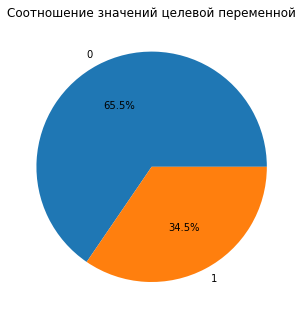

In [46]:
show_pie(y)

Несбалансированность данных не такая уж большая.

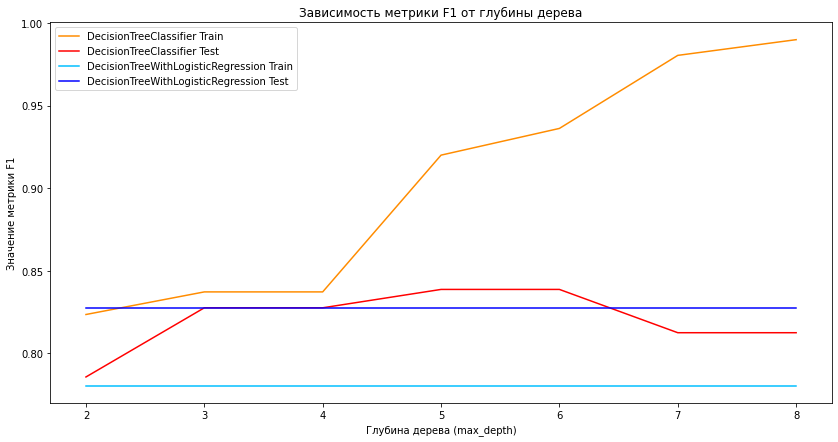

In [47]:
comparison_of_tree_models(X_train_scaled, y_train, X_test_scaled, y_test)

> Как видим, у эксперементальной модели значение метрики $F_1$ на тестовой выборке сравнимо со значением классической модели.\
> Но так же не растет.

Попробуем понять, почему у эксперементальной модели не растет значение метрики $F_1$ при увеличении глубины дерева.

## Исследование модели `DecisionTreeWithLogisticRegression` <a id="research"></a>

Продолжим работать с данными рассмотренной выше таблицы `data_biomed`.\
И выделим в ней два признака, наиболее значимые для логистической регрессии.

In [48]:
data_biomed.head()

,Age_of_patient,ml,m2,m3,m4,class
0,30,167.0,89.0,25.6,364.0,1
1,41,104.0,81.0,26.8,245.0,1
2,22,30.0,108.0,8.8,284.0,1
3,22,44.0,104.0,17.4,172.0,1
4,20,65.0,87.0,23.8,198.0,1


In [49]:
# построим и обучим логистическую регрессию
lr_model = linear_model.LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# посмотрим на ее коэффициенты
data_coefficients = pd.DataFrame({
    'coef': lr_model.coef_[0],
    'feature_name': lr_model.feature_names_in_,
})
data_coefficients.sort_values('coef', ascending=False)

,coef,feature_name
0,2.893149,Age_of_patient
4,2.376809,m4
3,1.584251,m3
2,1.572945,m2
1,1.413381,ml


Наибольшие коэффициенты при признаках `Age_of_patient` и `m4`.\
Их и оставим.

In [82]:
# предикторы
X = data_biomed[['Age_of_patient', 'm4']]
# целевой признак
y = data_biomed['class']

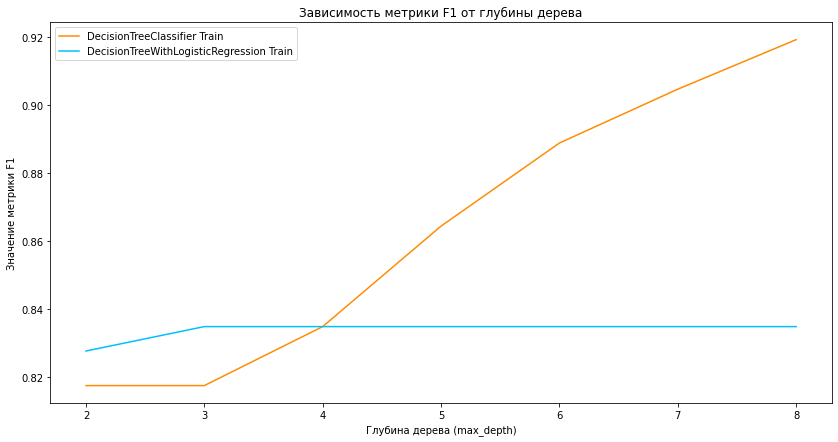

In [83]:
comparison_of_tree_models(X, y)

> Видим, что эксперементальная модель сначала обгоняет классическую.\
> Но после глубины дерева 3 значение метрики перестает расти.

In [75]:
# Вспомогательные функции для исследования

# цвета, в которые будем красить прямые логистической регрессии для каждой глубины дерева
colors = ['fuchsia', 'red', 'lime', 'aqua', 'blue', 'navy']


def display_colors_for_depth(depth: int):
    """Выводит цвета для переданной глубины дерева

    Args:
        colors (list): список цветов
        depth (int): глубина дерева
    """
    html = ''
    for i in range(depth):
        html += f'{i+1} - <font color="{colors[i]}">{colors[i]}</font>; '
    
    display(HTML(html))
    

def display_log_reg(node: Node, x_min: float, x_max: float, depth: int = 0):
    """Рекурсивно выводит прямые логистической регрессии на графике и печатает данные дерева

    Args:
        node (Node): Вершина дерева
        x_min (float): начало отрезка, на котором выводим прямую логистической регрессии
        x_max (float): конец отрезка, на котором выводим прямую логистической регрессии
        depth (int, optional): текущая глубина дерева. По умолчанию 0.
    """
    # цвет, соответствующий текущец глубине дерева
    color = colors[depth]
    # увеличиваем рассматриваемую глубину дерева
    depth += 1
    # отступ слева у данных вершины дерева
    indent = ('|' + ' '*18) * (depth-1)
    
    # если есть левая дочерняя вершина
    if (node.left is not None):
        # рекурсивно выводим о ней данные
        display_log_reg(node.left, x_min, x_max, depth)
    
    # если вершина пустая
    if (node is None):
        print(indent, '|--> ', 'None', sep='')
    # если вершина является листом
    elif node.is_leaf:
        # выводим предсказание для данного листа
        print(
            indent, 
            '|--> ', f'value: {node.value}; samples: {node.samples}; impurity: {node.impurity:.3f}', 
            sep=''
        )
        # если вершина является коневой или внутренней
    else:
        # по ссылке пример, как можно вывести прямую логистической регрессии
        # https://stackoverflow.com/questions/52858950/bad-logistic-regression-in-trivial-example-scikit-learn
        # коэффициенты логистической регрессии
        theta = node.log_reg_model.coef_[0, :]
        # свободный коэффициент
        y0 = node.log_reg_model.intercept_

        # координаты по оси X
        x_points = np.arange(x_min, x_max, 1)
        # координаты по оси Y
        y_points = -(y0+theta[0]*x_points) / theta[1]

        # выводим прямую логистической регрессии и красим ее цветом, соответствующим глубине дерева
        plt.plot(x_points, y_points, linewidth=2, color=color)        
        
        # печатаем данные о дереве
        print(indent, '|    ', f'depth: {depth}', sep='')
        print(indent, '|    ', f'samples: {node.samples}', sep='')
        print(indent, '|--> ', f'color: {color}', sep='')
        print(indent, '|    ', f'intercept_: {y0}', sep='')
        print(indent, '|    ', f'coef_: {theta}', sep='')
    
    # если есть правая дочерняя вершина
    if (node.right is not None):
        # рекурсивно выводим о ней данные
        display_log_reg(node.right, x_min, x_max, depth)
    

# Основная часть реализации данной функции взята из курса 
# "Профессия Data Scientist" https://skillfactory.ru/data-scientist-pro
def display_model_prediction_areas(
        X: pd.DataFrame, 
        y: pd.Series, 
        model: Union[
            tree.DecisionTreeClassifier, 
            DecisionTreeWithLogisticRegression, 
            linear_model.LogisticRegression
        ], 
        fig: plt.Figure,
    ):
    """Выводит график с закрашенными областями предсказания модели

    Args:
        X (pd.DataFrame): данные выборки
        y (pd.Series): истинные значения
        model (Union[ 
            tree.DecisionTreeClassifier, 
            DecisionTreeWithLogisticRegression, 
            linear_model.LogisticRegression 
        ]): обученная модель
        fig (plt.Figure): фигура
    """
    # минимальное значение по оси X
    x_min = X.iloc[:, 0].min()-1
    # максимальное значение по оси X
    x_max = X.iloc[:, 0].max()+1
    
    # генерируем координатную сетку из всех возможных значений для признаков
    # результат работы функции - два массива xx1 и xx2, которые образуют координатную сетку
    xx1, xx2 = np.meshgrid(
        np.arange(x_min, x_max, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    # вытягиваем каждый из массивов в вектор-столбец — reshape(-1, 1)
    # объединяем два столбца в таблицу с помощью hstack
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    # предсказываем вероятность для всех точек на координатной сетке
    y_pred = model.predict(X_net)
    # переводим столбец из вероятностей в размер координатной сетки
    y_pred = y_pred.reshape(xx1.shape)
    
    # рисуем тепловую карту предсказаний
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='bwr', alpha=0.3)
    # добавляем цветовую панель
    fig.colorbar(contour)
       
    # накладываем поверх тепловой карты диаграмму рассеяния с изначальными данными
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=40, hue=y, palette='seismic')
    # заголовок графика
    plt.title('Области предсказания модели')
    
    # если мы имеем дело с эксперементальной моделью
    if isinstance(model, DecisionTreeWithLogisticRegression):
        # выведем для нее прямую логистической регрессии
        display_log_reg(model.decision_tree, x_min=x_min, x_max=x_max)

Будем сравнивать работу моделей.\
Начнем с глубины дерева 1.

### Сравнение работы моделей при глубине дерева равной 1 <a id="max_depth_1"></a>

#### Модель `DecisionTreeClassifier` из `sklearn` <a id="max_depth_1_cart"></a>

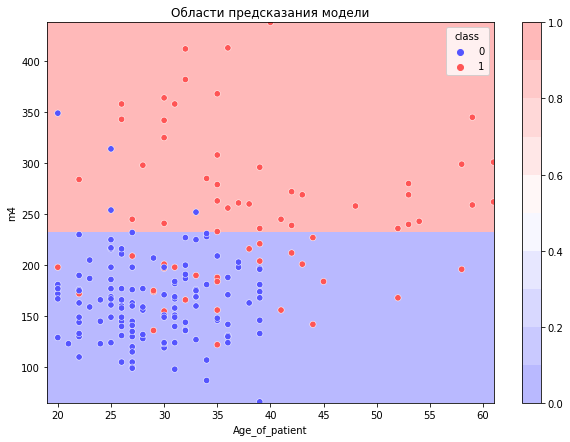

In [72]:
# инициализируем модель дерева решений с максимальной глубиной 1
cart_model = tree.DecisionTreeClassifier(max_depth=1)
# обучаем
cart_model.fit(X, y)

# визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
display_model_prediction_areas(X, y, cart_model, fig)

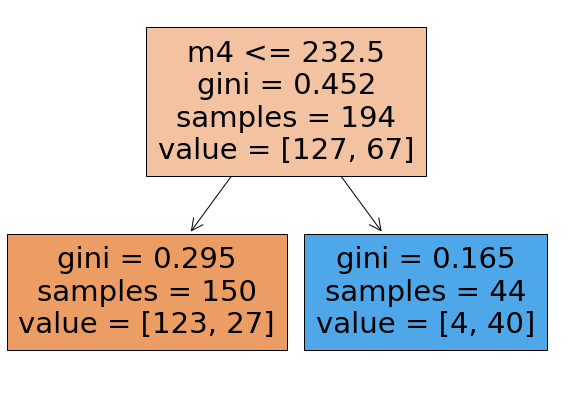

In [73]:
# выведем предикаты дерева решений
_, ax = plt.subplots(figsize=(10,7))

tree.plot_tree(
    decision_tree=cart_model, # дерево решений 
    feature_names=X.columns, # имена факторов
    filled=True, # расцветка
    impurity=True, # отображать ли неоднородность в вершинах
    ax=ax,
);

> Первое разделение произошло по предикату m4 <= 232.5, что и видим на графике.

#### Модель `DecisionTreeWithLogisticRegression` <a id="max_depth_1_custom"></a>

|                  |--> value: 0; samples: 136; impurity: 0.621
|    depth: 1
|    samples: 194
|--> color: fuchsia
|    intercept_: [-11.70999657]
|    coef_: [0.18160289 0.02584612]
|                  |--> value: 1; samples: 58; impurity: 0.736


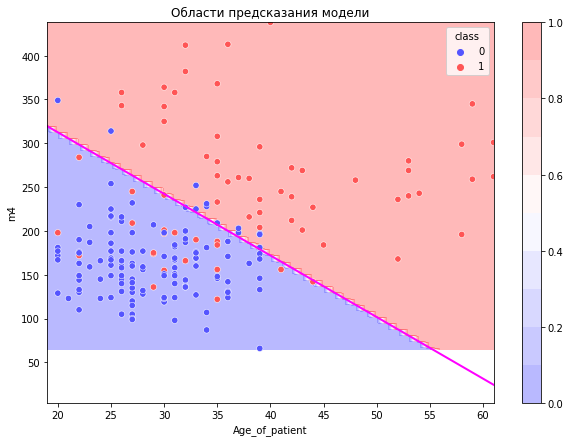

In [74]:
# инициализируем модель дерева решений с глубиной 1
custom_model = DecisionTreeWithLogisticRegression(max_depth=1)
# обучаем
custom_model.fit(X, y)

# визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
display_model_prediction_areas(X, y, custom_model, fig)

In [76]:
# вспомним порядок цветов, соответствующих глубире дерева 1
display_colors_for_depth(1)

Цвет <font color="fuchsia">fuchsia</font> соответствует прямой логистической регрессии, которая разделяет выборку на **первом** уровне глубины дерева.

> Видим, что на первом шаге эксперементальная модель справилась с разедением выборки неплохо.

### Сравнение работы моделей при глубине дерева равной 2 <a id="max_depth_2"></a>

#### Модель `DecisionTreeClassifier` из `sklearn` <a id="max_depth_2_cart"></a>

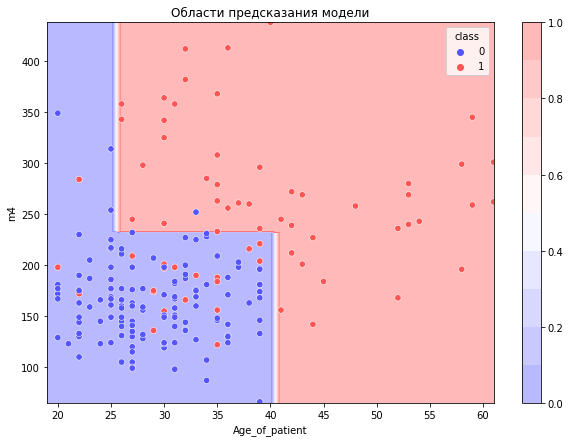

In [77]:
# инициализируем модель дерева решений с максимальной глубиной 2
cart_model = tree.DecisionTreeClassifier(max_depth=2)
# обучаем
cart_model.fit(X, y)

# визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
display_model_prediction_areas(X, y, cart_model, fig)

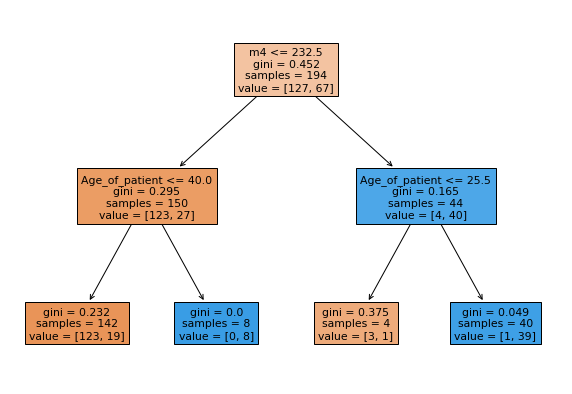

In [78]:
# выведем предикаты дерева решений
_, ax = plt.subplots(figsize=(10,7))

tree.plot_tree(
    decision_tree=cart_model, # дерево решений 
    feature_names=X.columns, # имена факторов
    filled=True, # расцветка
    impurity=True, # отображать ли неоднородность в вершинах
    ax=ax,
);

> Видим, что модель продолжает успешно делить выборку.

#### Модель `DecisionTreeWithLogisticRegression` <a id="max_depth_2_custom"></a>

|                  |                  |--> value: 0; samples: 132; impurity: 0.575
|                  |    depth: 2
|                  |    samples: 136
|                  |--> color: red
|                  |    intercept_: [-11.41013253]
|                  |    coef_: [0.15662956 0.02948325]
|                  |                  |--> value: 1; samples: 4; impurity: 0.811
|    depth: 1
|    samples: 194
|--> color: fuchsia
|    intercept_: [-11.70999657]
|    coef_: [0.18160289 0.02584612]
|                  |                  |--> value: 0; samples: 13; impurity: 0.391
|                  |    depth: 2
|                  |    samples: 58
|                  |--> color: red
|                  |    intercept_: [-96.79996574]
|                  |    coef_: [1.54701791 0.18124919]
|                  |                  |--> value: 1; samples: 45; impurity: -0.000


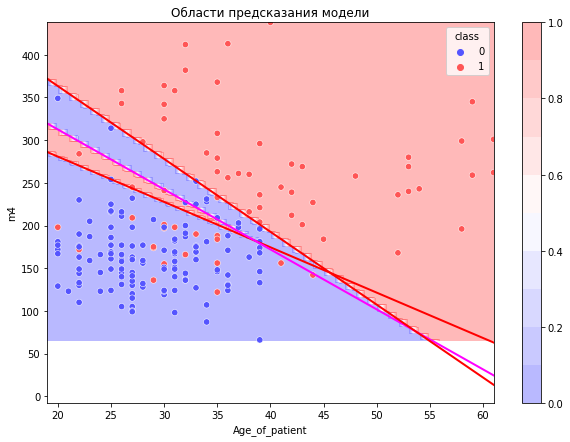

In [79]:
# инициализируем модель дерева решений с глубиной 2
custom_model = DecisionTreeWithLogisticRegression(max_depth=2)
# обучаем
custom_model.fit(X, y)

# визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
display_model_prediction_areas(X, y, custom_model, fig)

In [80]:
# вспомним порядок цветов, соответствующих глубине дерева 2
display_colors_for_depth(2)

Цвет <font color="fuchsia">fuchsia</font> соответствует прямой логистической регрессии, которая разделяет выборку на **первом** уровне глубины дерева.<br />
А цвет <font color="red">red</font> соответствует прямой логистической регрессии, которая разделяет выборку на **втором** уровне глубины дерева.

> Видим, что каждая половина выборки из 1-го шага\
> разделилась надвое новой логистической регрессией (красные прямые).

### Сравнение работы моделей при глубине дерева равной 3 <a id="max_depth_3"></a>

#### Модель `DecisionTreeClassifier` из `sklearn` <a id="max_depth_3_cart"></a>

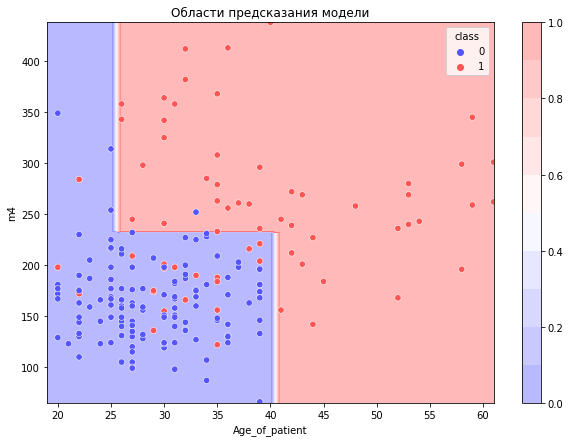

In [84]:
# инициализируем модель дерева решений с максимальной глубиной 3
cart_model = tree.DecisionTreeClassifier(max_depth=3)
# обучаем
cart_model.fit(X, y)

# визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
display_model_prediction_areas(X, y, cart_model, fig)

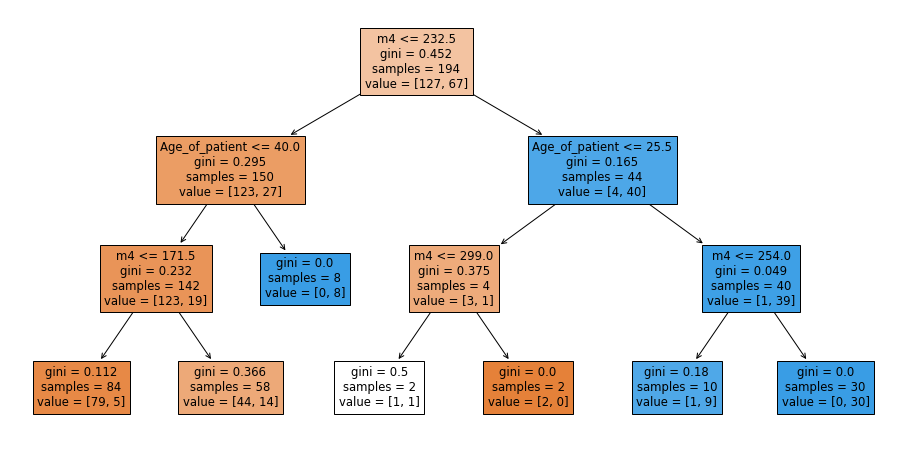

In [87]:
# выведем предикаты дерева решений
_, ax = plt.subplots(figsize=(16,8))

tree.plot_tree(
    decision_tree=cart_model, # дерево решений 
    feature_names=X.columns, # имена факторов
    filled=True, # расцветка
    impurity=True, # отображать ли неоднородность в вершинах
    ax=ax,
);

> Деление выборки продолжается.

#### Модель `DecisionTreeWithLogisticRegression` <a id="max_depth_3_custom"></a>

|                  |                  |                  |--> value: 0; samples: 132; impurity: 0.575
|                  |                  |    depth: 3
|                  |                  |    samples: 132
|                  |                  |--> color: lime
|                  |                  |    intercept_: [-10.62021076]
|                  |                  |    coef_: [0.16084067 0.02387413]
|                  |    depth: 2
|                  |    samples: 136
|                  |--> color: red
|                  |    intercept_: [-11.41013253]
|                  |    coef_: [0.15662956 0.02948325]
|                  |                  |                  |--> value: 0; samples: 1; impurity: -0.000
|                  |                  |    depth: 3
|                  |                  |    samples: 4
|                  |                  |--> color: lime
|                  |                  |    intercept_: [-109.6369735]
|                  |                  |    coef_

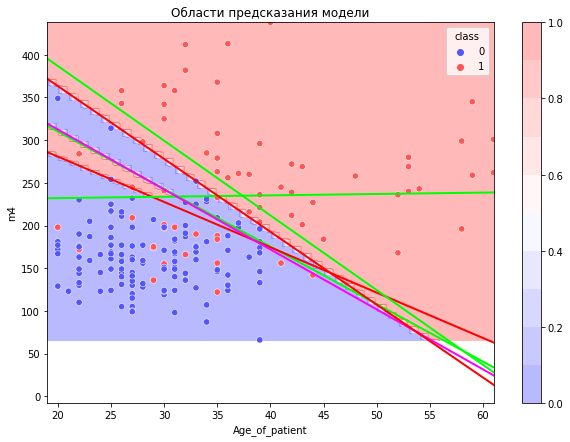

In [88]:
# инициализируем модель дерева решений с глубиной 3
custom_model = DecisionTreeWithLogisticRegression(max_depth=3)
# обучаем
custom_model.fit(X, y)

# визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
display_model_prediction_areas(X, y, custom_model, fig)

In [89]:
# вспомним порядок цветов, соответствующих глубине дерева 3
display_colors_for_depth(3)

Цвет <font color="fuchsia">fuchsia</font> соответствует прямой логистической регрессии, которая разделяет выборку на **первом** уровне глубины дерева.<br />
Цвет <font color="red">red</font> соответствует прямой логистической регрессии, которая разделяет выборку на **втором** уровне глубины дерева.<br />
Цвет <font color="lime">lime</font> соответствует прямой логистической регрессии, которая разделяет выборку на **третьем** уровне глубины дерева.

> Тут видим, что деление продолжается.\
Но самая левая вершина с количеством элементов `samples: 132` (она же на графике находится внизу слева и содержит наибольшее количество синих точек) не разделилась на 2 части, а сформировала только одну часть с предсказанием `0`.\
То же поведение видим для вершины с количеством элементов `samples: 13`.\
Построим для эксперементальной модели дерево с глубиной 4 и причина этого явления станет более очевидна.

### Сравнение работы моделей при глубине дерева равной 4 <a id="max_depth_4"></a>

#### Модель `DecisionTreeClassifier` из `sklearn` <a id="max_depth_4_cart"></a>

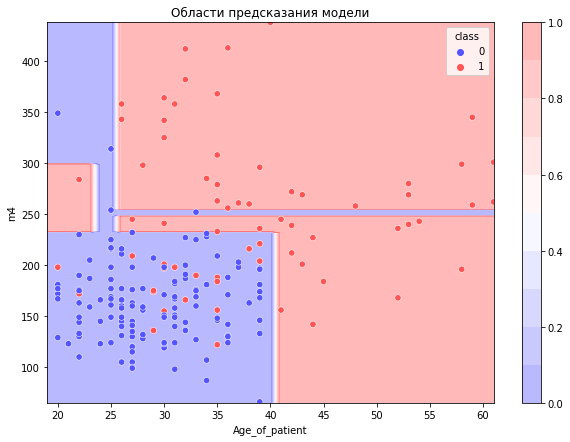

In [90]:
# инициализируем модель дерева решений с максимальной глубиной 4
cart_model = tree.DecisionTreeClassifier(max_depth=4)
# обучаем
cart_model.fit(X, y)

# визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
display_model_prediction_areas(X, y, cart_model, fig)

> Видим, что деление выборки продолжается.

#### Модель `DecisionTreeWithLogisticRegression` <a id="max_depth_4_custom"></a>

|                  |                  |                  |                  |--> value: 0; samples: 132; impurity: 0.575
|                  |                  |                  |    depth: 4
|                  |                  |                  |    samples: 132
|                  |                  |                  |--> color: aqua
|                  |                  |                  |    intercept_: [-10.62021076]
|                  |                  |                  |    coef_: [0.16084067 0.02387413]
|                  |                  |    depth: 3
|                  |                  |    samples: 132
|                  |                  |--> color: lime
|                  |                  |    intercept_: [-10.62021076]
|                  |                  |    coef_: [0.16084067 0.02387413]
|                  |    depth: 2
|                  |    samples: 136
|                  |--> color: red
|                  |    intercept_: [-11.41013253]
|             

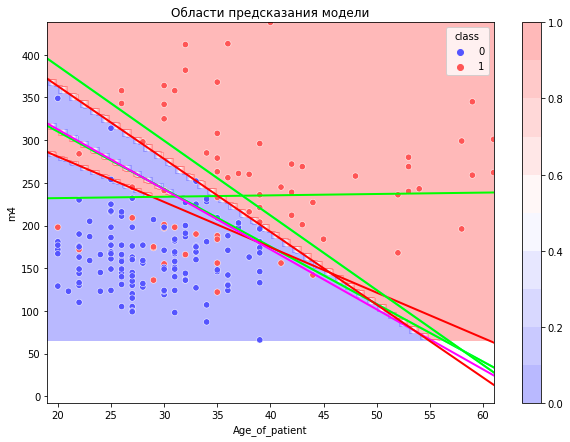

In [91]:
# инициализируем модель дерева решений с глубиной 4
custom_model = DecisionTreeWithLogisticRegression(max_depth=4)
# обучаем
custom_model.fit(X, y)

# визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
display_model_prediction_areas(X, y, custom_model, fig)

In [92]:
# вспомним порядок цветов, соответствующих глубине дерева 4
display_colors_for_depth(4)

Цвет <font color="fuchsia">fuchsia</font> соответствует прямой логистической регрессии, которая разделяет выборку на **первом** уровне глубины дерева.<br />
Цвет <font color="red">red</font> соответствует прямой логистической регрессии, которая разделяет выборку на **втором** уровне глубины дерева.<br />
Цвет <font color="lime">lime</font> соответствует прямой логистической регрессии, которая разделяет выборку на **третьем** уровне глубины дерева.\
Цвет <font color="aqua">aqua</font> соответствует прямой логистической регрессии, которая разделяет выборку на **четвертом** уровне глубины дерева.

<strong>Заметим, что мы не видим на графике прямых с цветом <font color="aqua">aqua</font>.</strong>

Также можно заметить, что у крайней левой вершины, которая содержит `132` элемента, \
на `3` и `4` уровне дерева совпадают свободный коэффициент `intercept_` и коэффициенты при признаках `coef_`.\
Аналогичное поведение наблюдается и для вершины, которая содержит `13` элементов.

То есть, выборка поделилась до того состояния, что логистическая регрессия перестает ее разделять.\
Посмотрим, как это выглядит.

Прямых с цветом <font color="aqua">aqua</font> не видно, потому что они совпадают с прямыми цвета <font color="lime">lime</font>.

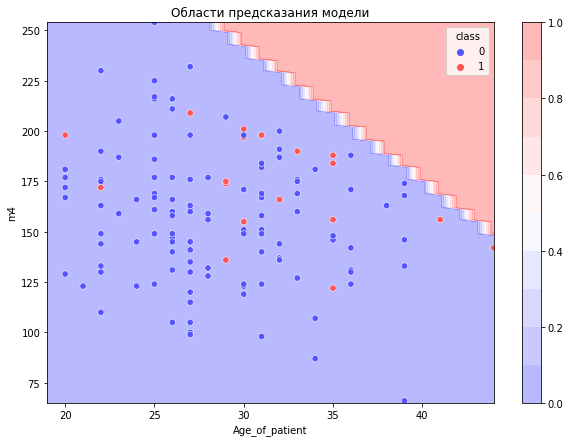

In [93]:
# данные выборки для крайней левой вершины при depth == 3
X_depth_3 = custom_model.decision_tree.left.left.X
# истинные значения для крайней левой вершины при depth == 3
y_depth_3 = custom_model.decision_tree.left.left.y

# построим логистическую регрессию
lg_model = linear_model.LogisticRegression(random_state=42, max_iter=1000)
# обучим 
lg_model.fit(X_depth_3, y_depth_3)

# визуализируем области предсказания
fig = plt.figure(figsize = (10, 7))
display_model_prediction_areas(X_depth_3, y_depth_3, lg_model, fig)

> Как видим, разделяющая линия проходит выше области точек и разделения не происходит.\
>Функция логистических потерь находит свой минимум для параметров, которые не разделяют выборку.\
>Можно сказать, что данные в этой части выборки линейно не разделимы.\
>В итоге, каждая из выборок приходит к аналогичному состоянию,\
>деление прекращается, поэтому метрика $F_1$ не растет при увеличении глубины дерева.

## Вывод <a id="result"></a>

Можно сделать вывод, что логистическая регрессия не подходит как предикат для разделения выборки дерева решений на каждом шаге.